In [101]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../experiments")


from experiment_information import *
from experiment_setup import *
from data import *
from helpers import *
from data_loading import *
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


import numpy as np
import re
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This code assumes that you have defined and run an experiment before using `define_experiment.ipynb` in the `experiments` folder.

In [102]:
df_experiments, df_state_evolution, df_erm = obtain_dataframes(logger)

Current code version, 105


In [103]:
df_experiments.head(5)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
81,862267e8-b807-41d4-80d7-9c10eb61f03f,FeatureComparisonsTest,139.308235,"[""Logistic""]",105,2024-02-08 14:57:22,1,0,"[0.1585, 0.3244, 0.6641, 1.3594, 2.7826, 5.695...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [104]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

862267e8-b807-41d4-80d7-9c10eb61f03f
Sweep
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[2 2]_SD_1_1_SU_1_1___FeatureComparisonsTest', 'KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[2 2]_SD_1_1_SU_1_1___FeatureComparisonsTest', 'KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[8 8]_SD_1_1_SU_1_1___FeatureComparisonsTest', 'KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[0.5 0.5]_SD_1_1_SU_1_1___FeatureComparisonsTest']
["2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity", "2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta Identity"]
FeatureComparisonsTest
['Logistic']


In [105]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1"] = "Robust Non-Useful"

data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[2 2]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[4 4]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[0.5 0.5]_SD_1_1_SU_1_1"] = "Robust Non-Useful"


data_model_name_dict['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[2 2]_SD_1_1_SU_1_1'] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[8 8]_SD_1_1_SU_1_1"] = "Non-Robust Useful"


In [106]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



In [107]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [108]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [109]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [110]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [111]:
def noiseless_angle_to_generalisation(angle):
    return np.arccos(angle) / np.pi

state_evolution["noiseless_angle_to_generalisation"] = state_evolution.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)
gd["noiseless_angle_to_generalisation"] = gd.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)

In [112]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [113]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)

In [114]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [115]:
def extract_theta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-1].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()
    

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_second # / theta_first  


state_evolution["theta_ratio"] = state_evolution["data_model_name"].apply(extract_theta_ratio)
gd["theta_ratio"] = gd["data_model_name"].apply(extract_theta_ratio)

In [116]:
def extract_sigmax_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-2].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_first # / theta_second


state_evolution["sigmax_ratio"] = state_evolution["data_model_name"].apply(extract_sigmax_ratio)
gd["sigmax_ratio"] = gd["data_model_name"].apply(extract_sigmax_ratio)

In [117]:
def extract_sigmadelta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_second  #/ theta_first

def extract_sigmadelta_scale(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_first


state_evolution["sigmadelta_ratio"] = state_evolution["data_model_name"].apply(extract_sigmadelta_ratio)
gd["sigmadelta_ratio"] = gd["data_model_name"].apply(extract_sigmadelta_ratio)

state_evolution["sigmadelta_scale"] = state_evolution["data_model_name"].apply(extract_sigmadelta_scale)
gd["sigmadelta_scale"] = gd["data_model_name"].apply(extract_sigmadelta_scale)

In [118]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6,7,8,9]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6,7,8,9]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                                                                      mean   
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                                            
0.1585   0.0     0.05 0.001 Logistic     0.2            0.5          1.0              2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5863.0   
                                                                                      8.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5940.0   
                                                        2.0          1.0              0.5         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5980.0   
                                                                                      2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5900.0   
         0.1     0.05 0.001 Logistic     0.2            0.5          1.0              2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5866.0   
...                                                                                                                                                                    ...   
100.0000 0.2     0.05 0.001 Logistic     0.2            2.0          1.0              2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5942.0   
         0.3     0.05 0.001 Logistic     0.2            0.5          1.0              2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5901.0   
                                                                                      8.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5978.0   
                                                        2.0          1.0              0.5         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                6019.0   
                                                                                      2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5939.0   

                                                                                                                                                          \
                                                                                                                                                     std   
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                          
0.1585   0.0     0.05 0.001 Logistic     0.2            0.5          1.0              2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                      8.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                        2.0          1.0              0.5         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                      2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.1     0.05 0.001 Logistic     0.2            0.5          1.0              2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
...                                                                                                                                                   ..   
100.0000 0.2     0.05 0.001 Logistic     0.2            2.0          1.0              2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.3     0.05 0.001 Logistic     0.2            0.5          1.0              2.0         KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN

In [119]:
def extract_rho_norm_usefulness(row):
    # extract sigmax_ratio from the index
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)

    norm = (sigmax_ratio + sigmatheta_ratio**2) * 0.5

    subspace_rho_1 = sigmax_ratio / (2 * norm)

    usefulness = subspace_rho_1 / ( 1 - subspace_rho_1 )

    subspace_rho_2 = sigmatheta_ratio**2 / (2*norm)

    assert subspace_rho_1 + subspace_rho_2 - 1 < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_rho_1, subspace_rho_2)


    return usefulness

def extract_trace_norm_usefulness(row):
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]
    rho = row["rho_state_evolution"]["mean"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)
    rho = float(rho)

    norm = (1/4) * (1 + sigmax_ratio) * ( 1 + sigmatheta_ratio**2)

    subspace_1 = 0.5 * sigmax_ratio / norm
    subspace_2 = 0.5 * sigmatheta_ratio**2 / norm

    # assert subspace_1 + subspace_2 - rho < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_1, subspace_2)

    usefulness = subspace_1 / ( rho - subspace_1 )

    return usefulness

def extract_relative_usefulness(row):
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)

    return sigmax_ratio / sigmatheta_ratio**2

def extract_usefulness(row):
    rho = row["rho_state_evolution"]["mean"]
    rho = float(rho)
    return rho


df2 = df.reset_index()


df2["total_usefulness"] = df2.apply(extract_usefulness, axis=1)

# # apply mean and std to the new column
# df_result = df2["total_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['total_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


df2["rho_usefulness"] = df2.apply(extract_rho_norm_usefulness, axis=1)


# apply mean and std to the new column
df_result = df2["rho_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['rho_usefulness'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

df2["trace_usefulness"] = df2.apply(extract_trace_norm_usefulness, axis=1)

# apply mean and std to the new column
df_result = df2["trace_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['trace_usefulness'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

df2["relative_usefulness"] = df2.apply(extract_relative_usefulness, axis=1)

# apply mean and std to the new column
# df_result = df2["relative_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['relative_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

# # apply mean and std to the column "theta_ratio"
# df_result = df2["theta_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['theta_ratio'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df_result = df2["sigmax_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['sigmax_ratio'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


# set all quantities from the df index in df2 as index
# df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","relative_usefulness","data_model_name"]) #,"p_calibration"
# df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) 
df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) #,"p_calibration"


# sort index
df.sort_index()



index_state_evolution  \
                                                                                                                                                                                       mean   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name                                                            
0.1585   0.0     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5980.0   
                                                        2.0         0.5          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5863.0   
                                                                    2.0          1.0              4.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5900.0   
                                                        8.0         0.5          1.0              4.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5940.0   
         0.1     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5981.0   
...                                                                                                                                                                                     ...   
100.0000 0.2     0.05 0.001 Logistic     0.2            8.0         0.5          1.0              4.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5977.0   
         0.3     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                6019.0   
                                                        2.0         0.5          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5901.0   
                                                                    2.0          1.0              4.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5939.0   
                                                        8.0         0.5          1.0              4.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro...                5978.0   

                                                                                                                                                                           \
                                                                                                                                                                      std   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name                                          
0.1585   0.0     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                        2.0         0.5          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                    2.0          1.0              4.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                        8.0         0.5          1.0              4.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
         0.1     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
...                                                                                                        

In [120]:
# try replacing data_model_name in df with data_model_name_dict
df = df.reset_index()
df["data_model_name"] = df["data_model_name"].apply(lambda x: data_model_name_dict[x])
df = df.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) #,"p_calibration"
df.sort_index()

index_state_evolution  \
                                                                                                                                                          mean   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name                               
0.1585   0.0     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              Robust Non-Useful                    5980.0   
                                                        2.0         0.5          1.0              1.0              Non-Robust Non-Useful                5863.0   
                                                                    2.0          1.0              4.0              Robust Useful                        5900.0   
                                                        8.0         0.5          1.0              4.0              Non-Robust Useful                    5940.0   
         0.1     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              Robust Non-Useful                    5981.0   
...                                                                                                                                                        ...   
100.0000 0.2     0.05 0.001 Logistic     0.2            8.0         0.5          1.0              4.0              Non-Robust Useful                    5977.0   
         0.3     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              Robust Non-Useful                    6019.0   
                                                        2.0         0.5          1.0              1.0              Non-Robust Non-Useful                5901.0   
                                                                    2.0          1.0              4.0              Robust Useful                        5939.0   
                                                        8.0         0.5          1.0              4.0              Non-Robust Useful                    5978.0   

                                                                                                                                              \
                                                                                                                                         std   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name             
0.1585   0.0     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              Robust Non-Useful     NaN   
                                                        2.0         0.5          1.0              1.0              Non-Robust Non-Useful NaN   
                                                                    2.0          1.0              4.0              Robust Useful         NaN   
                                                        8.0         0.5          1.0              4.0              Non-Robust Useful     NaN   
         0.1     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              Robust Non-Useful     NaN   
...                                                                                                                                       ..   
100.0000 0.2     0.05 0.001 Logistic     0.2            8.0         0.5          1.0              4.0              Non-Robust Useful     NaN   
         0.3     0.05 0.001 Logistic     0.2            0.5         2.0          1.0              1.0              Robust Non-Useful     NaN   
                                                        2.0         0.5          1.0              1.0              Non-Robust Non-Useful NaN   
                                                                    2.0          1.0              4.0              Robust Useful         NaN

In [121]:
# extract unique data_model_name from index
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['Non-Robust Non-Useful', 'Non-Robust Useful', 'Robust Non-Useful',
       'Robust Useful'],
      dtype='object', name='data_model_name')

In [122]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/feature_combinations_experiment.pkl"):
    df.to_pickle("Pickles/feature_combinations_experiment.pkl")

In [123]:
# load the pickle
df = pd.read_pickle("Pickles/feature_combinations_experiment.pkl")

# Extracting Data

In [124]:
# extract unique epsilons
epsilons = df.index.get_level_values("epsilon").unique()
epsilons

Index([0.0, 0.1, 0.2, 0.3], dtype='float64', name='epsilon')

In [125]:
# extract unique attack epsilons
attack_epsilons = df.index.get_level_values("attack_epsilon").unique()
attack_epsilons

Index([0.2], dtype='float64', name='attack_epsilon')

In [126]:
data_model_names = df.index.get_level_values("data_model_name").unique()
data_model_names

Index(['Non-Robust Non-Useful', 'Non-Robust Useful', 'Robust Non-Useful',
       'Robust Useful'],
      dtype='object', name='data_model_name')

In [127]:
dict_map_data_model_name = {}
dict_map_data_model_name['Non-Robust Non-Useful'] = "Low Robustness/Low Usefulness"
dict_map_data_model_name['Non-Robust Useful'] = "Low Robustness/High Usefulness"
dict_map_data_model_name['Robust Non-Useful'] = "High Robustness/Low Usefulness"
dict_map_data_model_name['Robust Useful'] = "High Robustness/High Usefulness"

In [128]:
# create a dictionary of dataframes for each data_model_name
df_dict = {}
for data_model_name in data_model_names:


    df_data_model = df.xs(data_model_name, level="data_model_name")

    # for each data_model_name, create a dictionary
    eps_dict = {}

    for epsilon in epsilons:


        eps_df = df_data_model.xs(epsilon, level="epsilon")

        alphas = eps_df.index.get_level_values("alpha").unique()
        adversarial_error_0 = eps_df["adversarial_generalization_error_state_evolution"]["mean"].values
        generalization_error_0 = eps_df["generalization_error_state_evolution"]["mean"].values
        boundary_error_0 = eps_df["difference_adv_gen_state_evolution"]["mean"].values
        class_preserving = eps_df["fair_adversarial_error_state_evolution"]["mean"].values

        rho = eps_df["rho_state_evolution"]["mean"].values
        qs = eps_df["q_state_evolution"]["mean"].values
        ms = eps_df["m_state_evolution"]["mean"].values
        # tau is in the index
        tau = eps_df.index.get_level_values("tau").unique()

        adversarial_error_erm = eps_df["adversarial_generalization_error_erm"]["mean"].values
        generalization_error_erm = eps_df["generalization_error_erm_erm"]["mean"].values
        boundary_error_erm = eps_df["difference_adv_gen_erm"]["mean"].values
        class_preserving_erm = eps_df["fair_adversarial_error_erm"]["mean"].values

        adversarial_error_erm_std = eps_df["adversarial_generalization_error_erm"]["std"].values
        generalization_error_erm_std = eps_df["generalization_error_erm_erm"]["std"].values
        boundary_error_erm_std = eps_df["difference_adv_gen_erm"]["std"].values
        class_preserving_erm_std = eps_df["fair_adversarial_error_erm"]["std"].values

        alphas = np.array(alphas)
        adversarial_error_0 = np.array(adversarial_error_0)
        generalization_error_0 = np.array(generalization_error_0)
        boundary_error_0 = np.array(boundary_error_0)
        class_preserving = np.array(class_preserving)

        adversarial_error_erm = np.array(adversarial_error_erm)
        generalization_error_erm = np.array(generalization_error_erm)
        boundary_error_erm = np.array(boundary_error_erm)
        class_preserving_erm = np.array(class_preserving_erm)

        adversarial_error_erm_std = np.array(adversarial_error_erm_std)
        generalization_error_erm_std = np.array(generalization_error_erm_std)
        boundary_error_erm_std = np.array(boundary_error_erm_std)
        class_preserving_erm_std = np.array(class_preserving_erm_std)

        rho = np.array(rho)
        rho = np.mean(rho)
        tau = np.array(tau)
        tau = np.mean(tau)

        ms = np.array(ms)
        qs = np.array(qs)

        eps_0_dict = {}
        eps_0_dict["alphas"] = alphas
        eps_0_dict["adversarial_error"] = adversarial_error_0
        eps_0_dict["generalization_error"] = generalization_error_0
        eps_0_dict["boundary_error"] = boundary_error_0
        eps_0_dict["class_preserving"] = class_preserving

        eps_0_dict["adversarial_error_erm"] = adversarial_error_erm
        eps_0_dict["generalization_error_erm"] = generalization_error_erm
        eps_0_dict["boundary_error_erm"] = boundary_error_erm
        eps_0_dict["class_preserving_erm"] = class_preserving_erm

        eps_0_dict["adversarial_error_erm_std"] = adversarial_error_erm_std
        eps_0_dict["generalization_error_erm_std"] = generalization_error_erm_std
        eps_0_dict["boundary_error_erm_std"] = boundary_error_erm_std
        eps_0_dict["class_preserving_erm_std"] = class_preserving_erm_std

        eps_0_dict["rho"] = rho
        eps_0_dict["tau"] = tau

        eps_0_dict["ms"] = ms
        eps_0_dict["qs"] = qs


        eps_dict[epsilon] = eps_0_dict

    dm_name = dict_map_data_model_name[data_model_name]

    df_dict[dm_name] = eps_dict


In [129]:
# df_dict['Non-Robust Non-Useful'][0.2]["generalization_error"]

# Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Figure size:  [8.5 2.4]


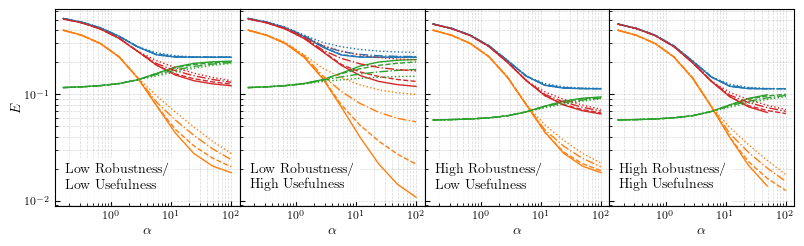

In [130]:

IMG_DIRECTORY = "./Assets/feature_combination_sweeps"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# width = 2.5 * 458.63788


plt.style.use("../latex_ready.mplstyle")

multiplier = 1.25
width = multiplier * 487.8225
tuple_size = set_size(width, subplots=(1,2))
tuple_size = (8.5,2.4)


second_multiplier = 0.7


fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=( tuple_size[0], tuple_size[1]),
    gridspec_kw={"hspace": 0,"wspace": 0},
)


# ICML adjustments
fig.subplots_adjust(left=0.12)
fig.subplots_adjust(bottom=0.08)
fig.subplots_adjust(top=0.9)
fig.subplots_adjust(right=0.99)
# plt.subplots_adjust(bottom=0.20)

# log the figure size
print("Figure size: ", fig.get_size_inches())


from matplotlib.lines import Line2D

axes = axes.flatten()

# Create a custom legend
legend_elements = [Line2D([0], [0], color='blue', label='Line 1'),
                   Line2D([0], [0], color='orange', label='Line 2')]
custom_legend = []

from scipy.special import erfc
from scipy.integrate import quad


for df_idx, (key, value) in enumerate(df_dict.items()):

    data_model_name = key

    axs = axes[df_idx]
    
    # if df_idx> 0:
    #     continue


    linestyles = ["solid", "dashed", "dashdot", "dotted"]



    for idx, (epsilon, eps_dict) in enumerate(value.items()):

        ax = axes[idx]

        alphas = eps_dict["alphas"]
        adversarial_error = eps_dict["adversarial_error"]
        generalization_error = eps_dict["generalization_error"]
        boundary_error = eps_dict["boundary_error"]
        class_preserving = eps_dict["class_preserving"]

        adversarial_error_erm = eps_dict["adversarial_error_erm"]
        generalization_error_erm = eps_dict["generalization_error_erm"]
        boundary_error_erm = eps_dict["boundary_error_erm"]
        class_preserving_erm = eps_dict["class_preserving_erm"]

        rho = eps_dict["rho"]
        tau = eps_dict["tau"]

        qs = eps_dict["qs"]
        ms = eps_dict["ms"]


        adversarial_error_erm_std = eps_dict["adversarial_error_erm_std"]
        generalization_error_erm_std = eps_dict["generalization_error_erm_std"]
        boundary_error_erm_std = eps_dict["boundary_error_erm_std"]
        class_preserving_erm_std = eps_dict["class_preserving_erm_std"]

        if df_idx == 0:

            custom_legend.append(Line2D([0],[0],color="C0", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{adv}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C1", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{gen}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C2", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{bound}}}}, \varepsilon_t={}$".format(epsilon)))
            custom_legend.append(Line2D([0],[0],color="C3", linestyle=linestyles[idx], label=r"$E_{{\mathrm{{CP}}}}, \varepsilon_t={}$".format(epsilon)))
        




        adversarial_lines = axs.plot(alphas, adversarial_error, linestyle=linestyles[idx],color="C0")
        axs.plot(alphas, generalization_error, linestyle=linestyles[idx],color="C1")
        
        # axs.plot(alphas, np.arccos(ms/np.sqrt(rho*qs))/np.pi, linestyle=linestyles[idx],color="C5")
        axs.plot(alphas, boundary_error,linestyle=linestyles[idx], color="C2")
        
        axs.plot(alphas, class_preserving,linestyle=linestyles[idx], color="C3")

        

        def integrand(xi):
            return erfc(-np.sqrt(rho)/tau * xi * (1/np.sqrt(2))) * np.exp(-xi**2 / 2) / np.sqrt(2*np.pi)
        
        # def integrand(xi):
        #     a = 1 / np.sqrt(1 + tau**2/rho)
        #     return erfc(- a / np.sqrt(2*(1-a**2)) * xi) * np.exp(-xi**2 / 2) / np.sqrt(2*np.pi)
        
        psi_i = 0.5
        if df_idx > 1:
            psi_i = 2

        I = quad(integrand, 0, 0.2 / np.sqrt(psi_i))[0]

        # if idx == 0:

        #     plot_range = alphas[4*len(alphas)//5:]

        #     axs.plot(plot_range, np.ones(len(plot_range)) * np.arccos(1/np.sqrt(1+tau**2/rho))/np.pi, linestyle=linestyles[0],color="black")
        #     axs.plot(plot_range, np.ones(len(plot_range))*I,linestyle=linestyles[0], color="black")

        

        # plot a horizontal line at two-thirds of the x axis until the right end of the plot at a constant values


        axs.errorbar(
            alphas,
            adversarial_error_erm,
            yerr=adversarial_error_erm_std,
            fmt=".",
            markersize=1,
            color="C0"
        )
        axs.errorbar(
            alphas,
            generalization_error_erm,
            yerr=generalization_error_erm_std,
            fmt=".",
            markersize=1,
            color="C1"
        )
        axs.errorbar(
            alphas,
            boundary_error_erm,
            yerr=boundary_error_erm_std,
            fmt=".",
            markersize=1,
            color="C2"
        )
        axs.errorbar(
            alphas,
            class_preserving_erm,
            yerr=class_preserving_erm_std,
            fmt=".",
            markersize=1,
            color="C3"
        )


    axs.set_xscale("log")
    axs.set_yscale("log")


    if df_idx  == 0:
        axs.set_ylabel(r"$E$", labelpad=2.0)
    # axs.set_ylabel(r"$E$", labelpad=2.0)


    axs.set_xlabel(r"$\alpha$", labelpad=2.0)
    axs.grid(which="both", axis="both", alpha=0.5)
    axs.legend(title=data_model_name.replace("/","/\n"), loc="lower left")
    # Set the major ticks to face inwards
    axs.tick_params(axis='both', which='major', direction='in')

    # Set the minor ticks to face inwards
    axs.tick_params(axis='both', which='minor', direction='in')


error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))


epsilon_legend = []

for idx, epsilon in enumerate(epsilons):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 

custom_legend = []

# mix the two legends
for idx in range(len(error_legend)):
    custom_legend.append(error_legend[idx])
    custom_legend.append(epsilon_legend[idx])

# Place the legend at the bottom of the figure
# fig.legend(handles=custom_legend, loc='upper center', ncol=4)

save = True
if save:
    save_plot(
        fig,
        f"feature_combinations_alpha_sweep",
    )

plt.show()



Figure size:  [0.85 1.32]


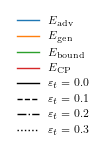

In [131]:


error_legend = []

error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{adv}}$",color="C0"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{gen}}$",color="C1"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{bound}}$",color="C2"))
error_legend.append(Line2D([0],[0],label=r"$E_{\mathrm{CP}}$",color="C3"))


epsilon_legend = []

for idx, epsilon in enumerate(epsilons):
    epsilon_legend.append(Line2D([0],[0],color="black", linestyle=linestyles[idx], label=r"$\varepsilon_t={}$".format(epsilons[idx]))) 

custom_legend = error_legend + epsilon_legend

# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( 0.1 * tuple_size[0],0.55 *tuple_size[1]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

# print figsize
print("Figure size: ", figlegend.get_size_inches())

figlegend.legend(
    handles=custom_legend,
    handlelength=2,
    loc="center",
    ncol=1,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "legend.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()



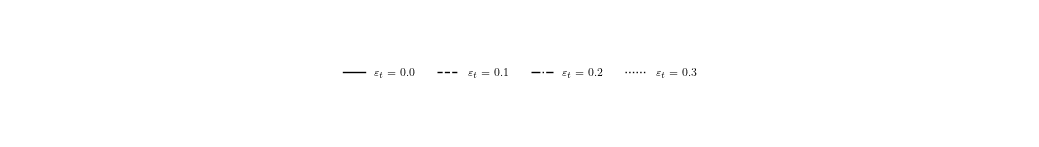

In [132]:


# save the legend separately, put the custom legend into a figure
figlegend = plt.figure(figsize=( 1.2 * tuple_size[0],0.15 * tuple_size[0]))
plt.style.use("../latex_ready.mplstyle")
legend_ax = figlegend.add_axes([0, 0, 1, 1])
legend_ax.axis('off')  # Turn off the axes for the legend figure

figlegend.legend(
    handles=epsilon_legend,
    handlelength=2,
    loc="center",
    ncol=5,
)

figlegend.savefig(
    os.path.join(IMG_DIRECTORY, "feature_combinations_alpha_sweep_legend_epsilon.pdf"),
    format="pdf",
    # bbox_inches="tight",
)


plt.show()

